In [1]:
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, OPTICS, DBSCAN
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score, ConfusionMatrixDisplay
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
import seaborn as sns
import matplotlib.pyplot as plt

Number of Clusers for KMeans = 5


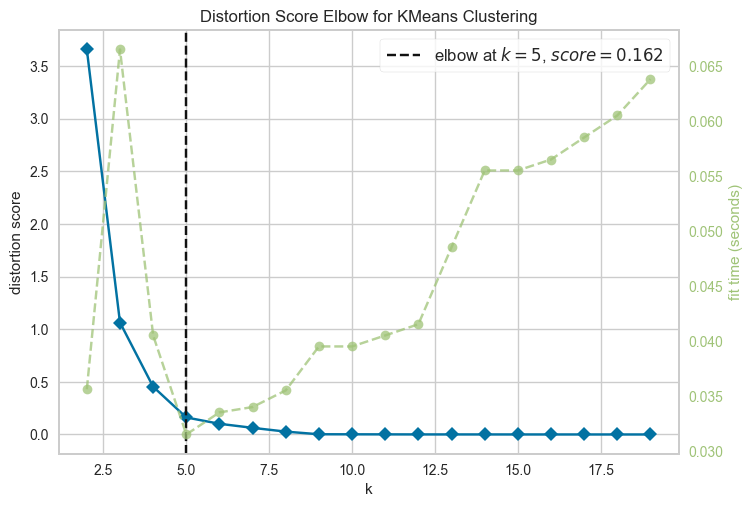

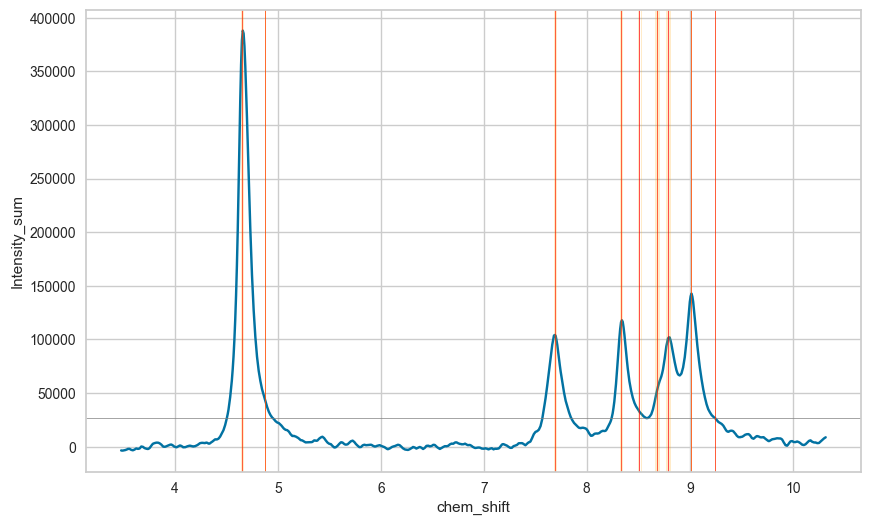

In [13]:


def peak_threshold( filename):
    # read specified file
    data = pd.read_csv(f"../Data/{filename}")
  
    #  sum of spectra
    sum_spec = pd.DataFrame()
    sum_spec['chem_shift'] = data.iloc[:, 0] 
    sum_spec['Intensity_sum']= data.iloc[:, 1:].sum(axis=1)
    
    #set threshold
    threshold = np.percentile(sum_spec['Intensity_sum'], 75)
    
    #add derivatives to spectra
    sum_spec['1st derivative'] = np.gradient(sum_spec['Intensity_sum'], sum_spec['chem_shift'])
    sum_spec['2nd derivative'] = np.gradient(sum_spec['1st derivative'], sum_spec['chem_shift'])
    sum_spec['3rd derivative'] = np.gradient(sum_spec['2nd derivative'], sum_spec['chem_shift'])
    sum_spec['4th derivative'] = np.gradient(sum_spec['3rd derivative'], sum_spec['chem_shift'])

    sum_spec['sign_change'] = sum_spec['3rd derivative'].diff().lt(0) != sum_spec['3rd derivative'].shift().lt(0)

    # Filtere die Zeilen, in denen ein Vorzeichenwechsel festgestellt wurde
    peak_pos = sum_spec[(sum_spec['sign_change'])           #problem !!!
                                & (sum_spec['Intensity_sum'] > threshold) 
                                & (sum_spec['2nd derivative'] < 0)
                                & (sum_spec['4th derivative'] > 0)]['chem_shift'].tolist()

    #print(peak_pos)
    peak_pos_2d = np.array(peak_pos)
    peak_pos_2d = peak_pos_2d.reshape(-1, 1)

    kmeans_sc = KMeans(random_state=42, n_init=10)
    # print(k_values,silhouette_values)

    from yellowbrick.cluster import KElbowVisualizer
    visualizer = KElbowVisualizer(kmeans_sc, k=(2, 20))
    visualizer.fit(peak_pos_2d)        # Fit the data to the visualizer
    k_value_KMeans = visualizer.elbow_value_

    print(f'Number of Clusers for KMeans = {k_value_KMeans}')
    visualizer.show();

    
    # Applying KMeans
    kmeans = KMeans(n_clusters=9, random_state=42, n_init=10)
    kmeans.fit(peak_pos_2d)
    cluster_assignments = kmeans.labels_

    df_cluster = {}
    df_cluster['data'] = peak_pos_2d.reshape(-1)
    df_cluster['cluster_assignments'] = cluster_assignments
    df_cluster = pd.DataFrame(df_cluster)
    df_cluster_grouped = df_cluster.groupby(by=['cluster_assignments']).mean()
    #display(df_cluster_grouped)

    # visualize
    plt.figure(figsize=(10, 6))
    sns.lineplot(sum_spec, x= 'chem_shift', y= 'Intensity_sum')
    plt.axhline(threshold, color = 'grey', linewidth = 0.5)
    
    for pos in df_cluster_grouped.data:
        plt.axvline(pos, color='red', linewidth=0.5)#, linestyle='--')

    for pos in peak_pos:
        plt.axvline(pos, color='orange', linewidth=0.5, alpha=0.3)

    #plt.show()

    return None

peak_threshold('../Data/FA_20240108_2H_yeast_Nicotinamide-d4 _7.csv')

In [3]:
df= pd.read_csv('../Data/FA_20240108_2H_yeast_Nicotinamide-d4 _7.csv')

---
---
# grouped spectra

In [4]:
def grouped_peak_analysis(filename):
    # Daten einlesen
    data = pd.read_csv(f"../Data/{filename}")
    
    chem_shift = data.iloc[:, 0]  # Chemische Verschiebungen
    
    # Anzahl der Gruppen bestimmen (jede Gruppe besteht aus 10 Spektren)
    num_groups = (len(data.columns) - 1) // 10
    
    for i in range(num_groups):
        start_col = 1 + i * 10
        end_col = start_col + 10
        
        # Gruppensumme berechnen
        group_sum = data.iloc[:, start_col:end_col].sum(axis=1)
        
        spec = pd.DataFrame()
        spec['chem_shift'] = chem_shift
        spec['Intensity_sum'] = group_sum
        
        # Schwellenwert festlegen
        threshold = np.percentile(spec['Intensity_sum'], 75)
        
        # Ableitungen hinzufügen
        spec['1st derivative'] = np.gradient(spec['Intensity_sum'], spec['chem_shift'])
        spec['2nd derivative'] = np.gradient(spec['1st derivative'], spec['chem_shift'])
        spec['3rd derivative'] = np.gradient(spec['2nd derivative'], spec['chem_shift'])
        spec['4th derivative'] = np.gradient(spec['3rd derivative'], spec['chem_shift'])

        spec['sign_change'] = spec['3rd derivative'].diff().lt(0) != spec['3rd derivative'].shift().lt(0)

        # Filter für Peaks
        peak_pos = spec[(spec['sign_change'])
                         & (spec['Intensity_sum'] > threshold) 
                         & (spec['2nd derivative'] < 0) 
                         & (spec['4th derivative'] > 0)]['chem_shift'].tolist()

        # Visualisierung
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=spec, x='chem_shift', y='Intensity_sum')
        plt.axhline(threshold, color='grey', linewidth=0.5)

        for pos in peak_pos:
            plt.axvline(pos, color='red', linewidth=0.5)

        plt.title(f"Summe der Spektren Gruppe {i+1}")
        plt.show()

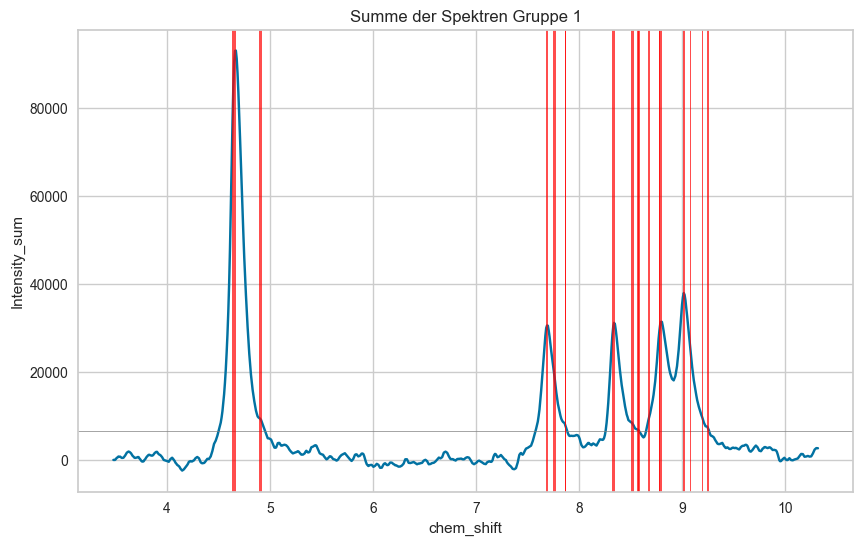

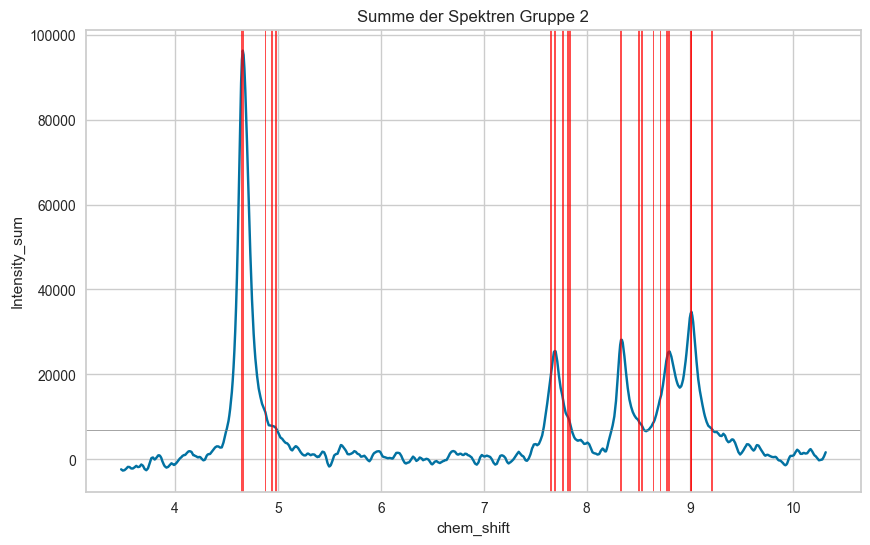

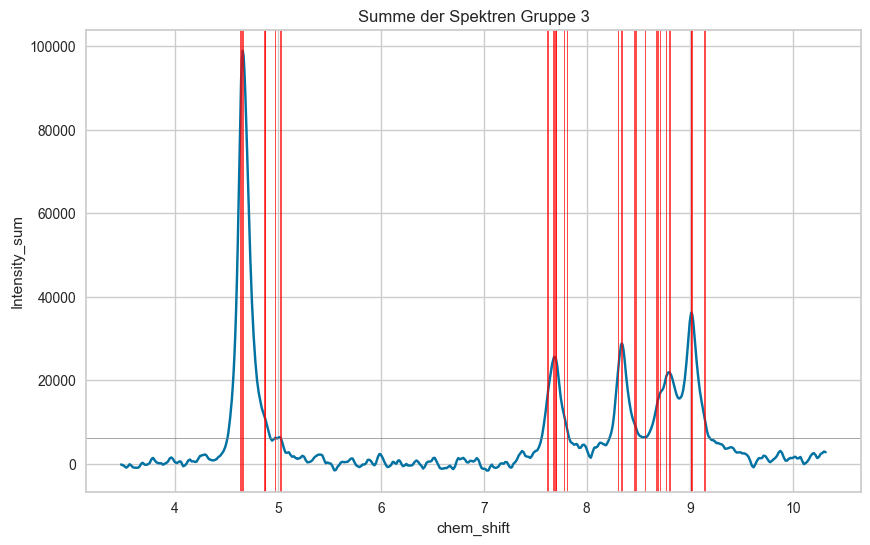

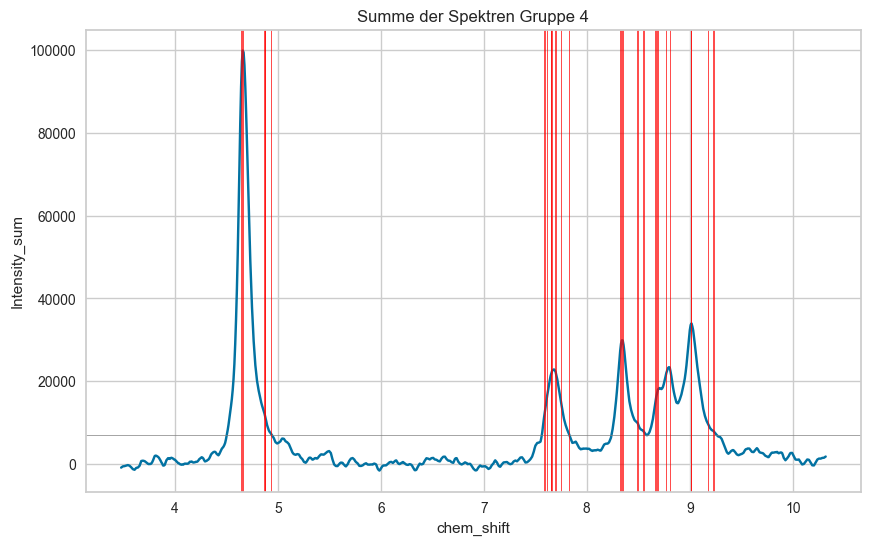

In [5]:
grouped_peak_analysis('FA_20240108_2H_yeast_Nicotinamide-d4 _7.csv')

---
---
# 3D

In [6]:
def xpeak_threshold_3d(filename):
    # Daten einlesen
    data = pd.read_csv(f"../Data/{filename}")

    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    chem_shifts = data.iloc[:, 0].values

    for i, col in enumerate(data.columns[1:]):  # Ignoriere die erste Spalte für chem_shift
        intensity = data[col].values
        
        # Set threshold
        threshold = np.percentile(intensity, 75)
        
        # Berechne erste bis vierte Ableitung
        first_derivative = np.gradient(intensity, chem_shifts)
        second_derivative = np.gradient(first_derivative, chem_shifts)
        third_derivative = np.gradient(second_derivative, chem_shifts)
        fourth_derivative = np.gradient(third_derivative, chem_shifts)
        
        sign_change = np.diff(np.sign(third_derivative)) != 0
        
        # Finde Peaks
        peak_mask = (intensity > threshold) & (second_derivative < 0) & (fourth_derivative > 0)
        peak_mask[1:] &= sign_change
        
        peak_pos = chem_shifts[peak_mask]
        
        ax.scatter(peak_pos, [i] * len(peak_pos), intensity[peak_mask], c='r', marker='o')
        
        # Zeichne das Spektrum
        ax.plot(chem_shifts, [i] * len(chem_shifts), intensity, color='b')

    ax.set_xlabel('Chem Shift')
    ax.set_ylabel('Time/Spektrum Number')
    ax.set_zlabel('Intensity')
    plt.show()

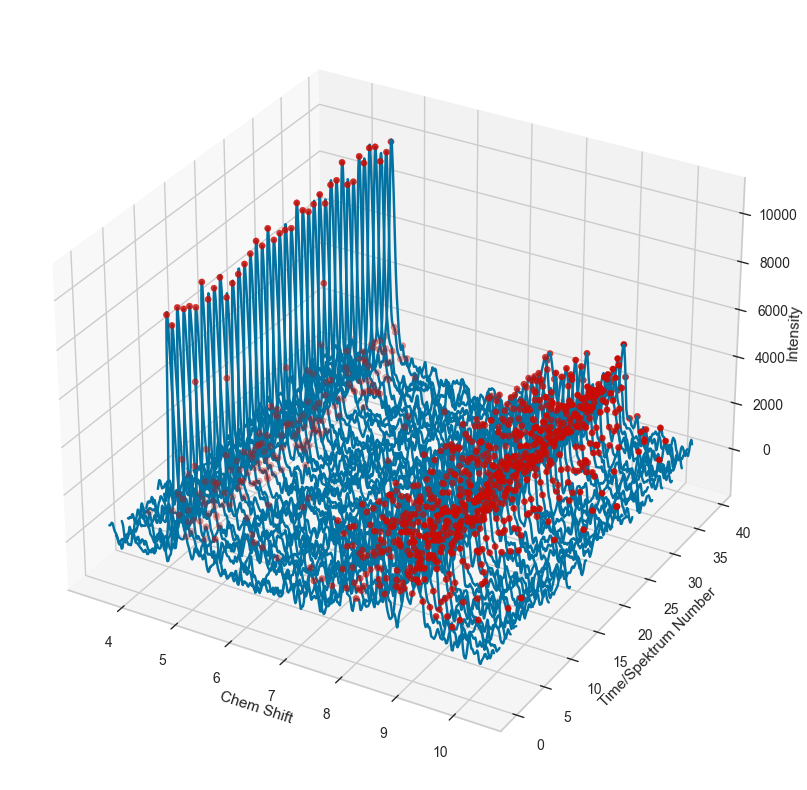

In [7]:
xpeak_threshold_3d('FA_20240108_2H_yeast_Nicotinamide-d4 _7.csv')

In [8]:
def peak_threshold_3d(filename):
    # Daten einlesen
    data = pd.read_csv(f"../Data/{filename}")

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    
    chem_shifts = data.iloc[:, 0].values

    for i, col in enumerate(data.columns[1:]):  # Ignoriere die erste Spalte für chem_shift
        intensity = data[col].values
        
        # Set threshold
        threshold = np.percentile(intensity, 75)
        
        # Berechne Ableitungen
        first_derivative = np.gradient(intensity, chem_shifts)
        second_derivative = np.gradient(first_derivative, chem_shifts)
        third_derivative = np.gradient(second_derivative, chem_shifts)
        fourth_derivative = np.gradient(third_derivative, chem_shifts)
        
        sign_change = np.diff(np.sign(third_derivative)) != 0

        # Peaks finden
        peak_mask = (intensity > threshold) & (second_derivative < 0) & (fourth_derivative > 0)
        peak_mask[1:] &= sign_change
        
        peak_pos = chem_shifts[peak_mask]
        
        ax.scatter(peak_pos, [i] * len(peak_pos), intensity[peak_mask], c='r', marker='o')
        
        # Zeichne das Spektrum
        ax.plot(chem_shifts, [i] * len(chem_shifts), intensity, color='b')

    ax.set_xlabel('Chem Shift')
    ax.set_ylabel('Time/Spektrum Number')
    ax.set_zlabel('Intensity')
    plt.show()


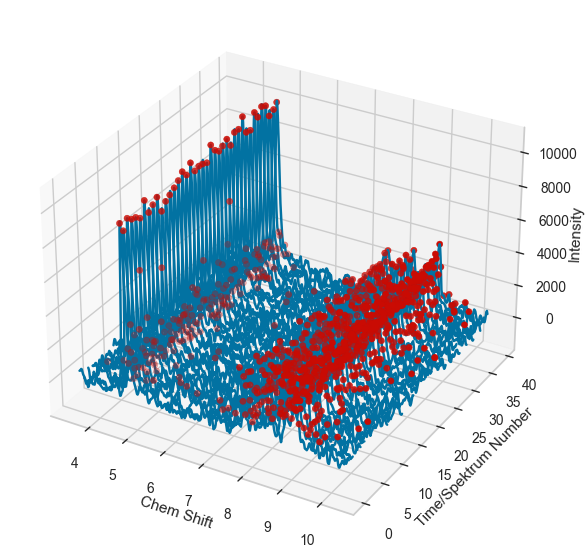

In [9]:
peak_threshold_3d('FA_20240108_2H_yeast_Nicotinamide-d4 _7.csv')

---
---
# individual spectra

In [10]:
def individual_peak_analysis(filename):
    # Daten einlesen
    data = pd.read_csv(f"../Data/{filename}")
    
    chem_shift = data.iloc[:, 0]  # Chemische Verschiebungen
    
    for col in data.columns[1:]:
        spec = pd.DataFrame()
        spec['chem_shift'] = chem_shift
        spec['Intensity'] = data[col]
        
        # Schwellenwert festlegen
        threshold = np.percentile(spec['Intensity'], 75)
        
        # Ableitungen hinzufügen
        spec['1st derivative'] = np.gradient(spec['Intensity'], spec['chem_shift'])
        spec['2nd derivative'] = np.gradient(spec['1st derivative'], spec['chem_shift'])
        spec['3rd derivative'] = np.gradient(spec['2nd derivative'], spec['chem_shift'])
        spec['4th derivative'] = np.gradient(spec['3rd derivative'], spec['chem_shift'])

        spec['sign_change'] = spec['3rd derivative'].diff().lt(0) != spec['3rd derivative'].shift().lt(0)

        # Filter für Peaks
        peak_pos = spec[(spec['sign_change'])
                         & (spec['Intensity'] > threshold) 
                         & (spec['2nd derivative'] < 0) 
                         & (spec['4th derivative'] > 0)]['chem_shift'].tolist()

        # Visualisierung
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=spec, x='chem_shift', y='Intensity')
        plt.axhline(threshold, color='grey', linewidth=0.5)

        for pos in peak_pos:
            plt.axvline(pos, color='red', linewidth=0.5)

        plt.title(f"Spektrum Analyse: {col}")
        plt.show()

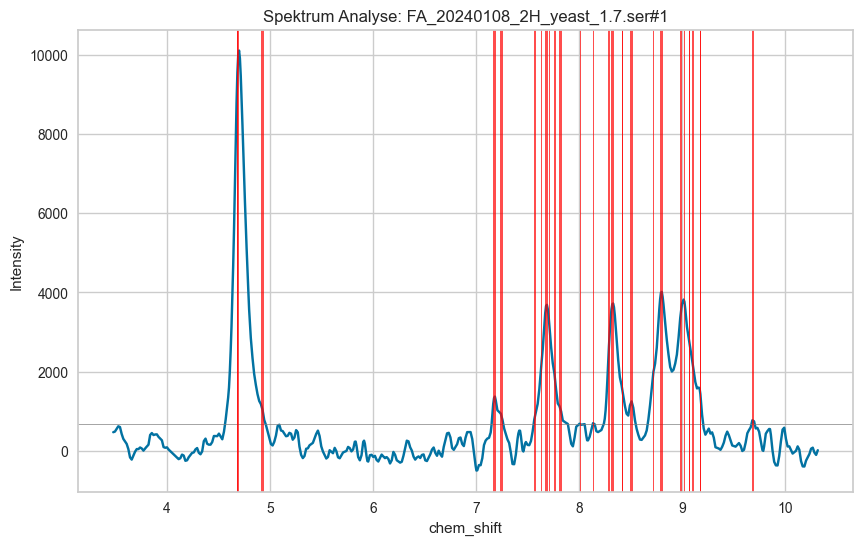

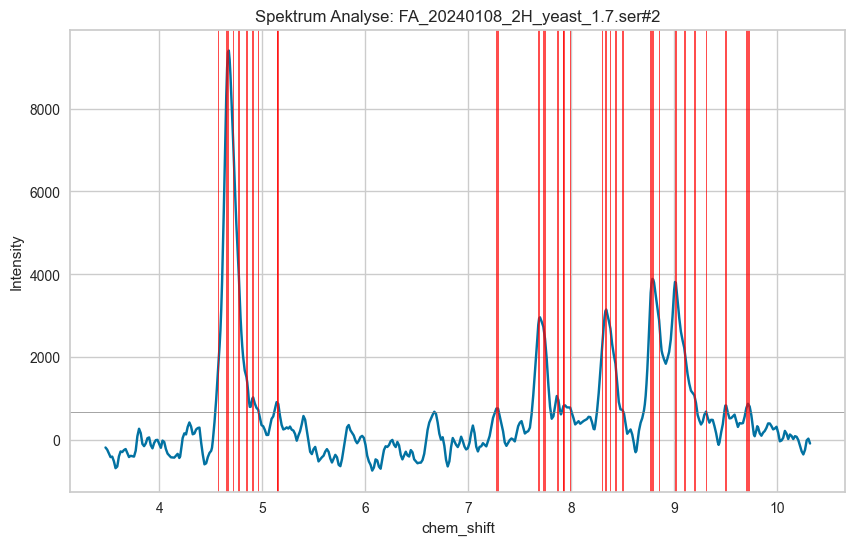

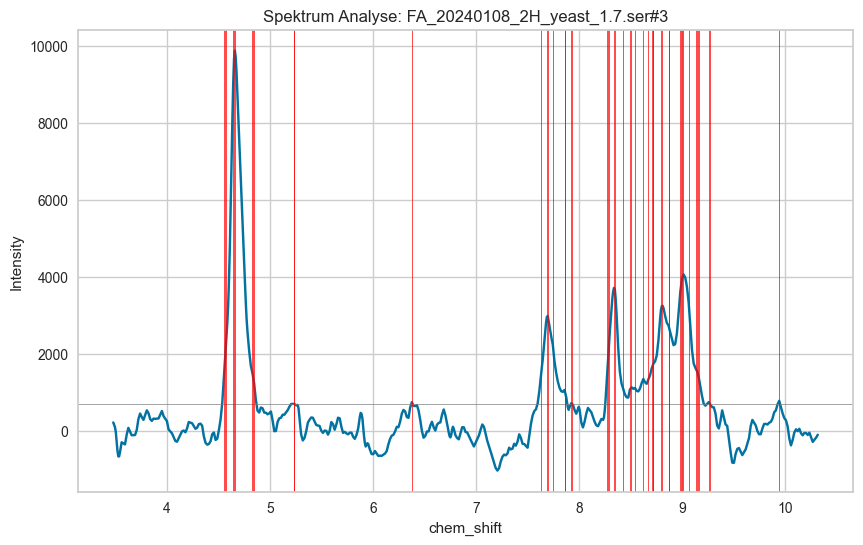

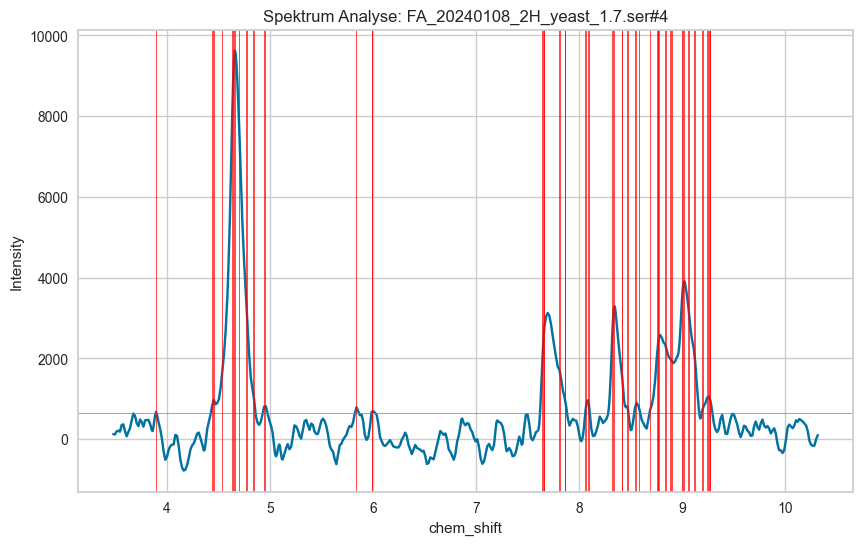

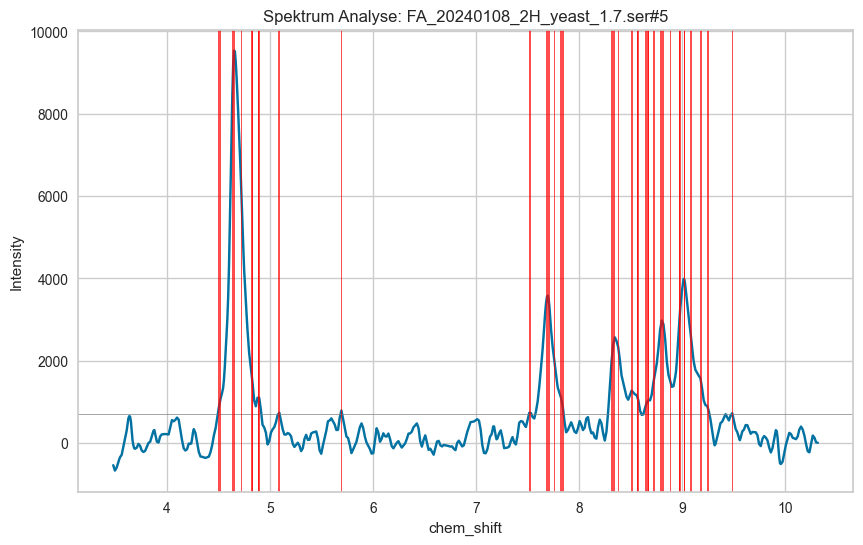

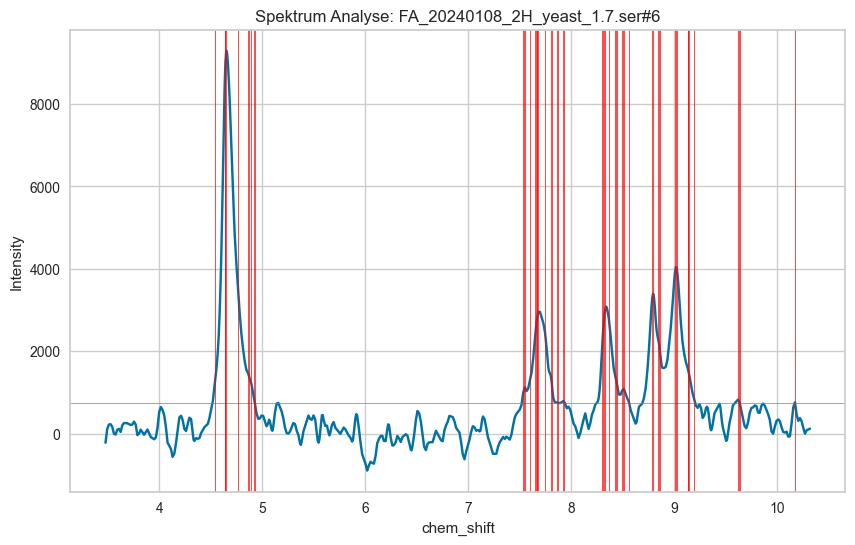

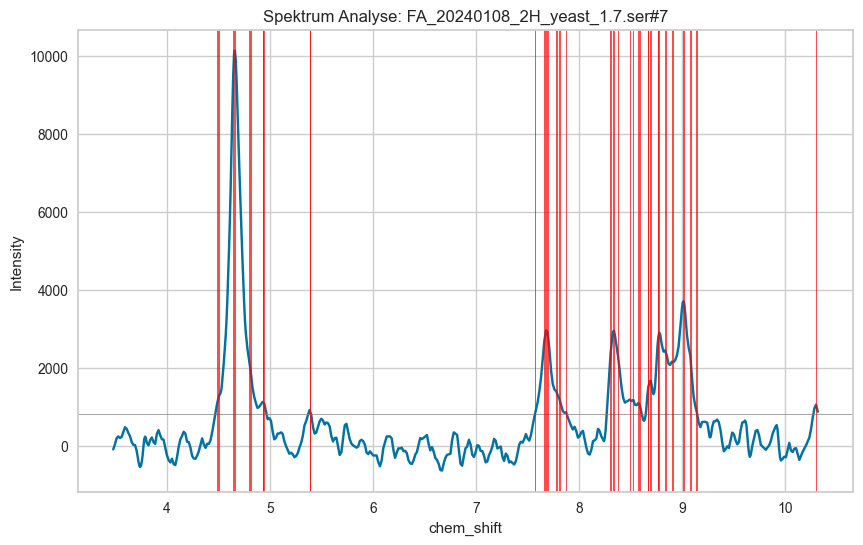

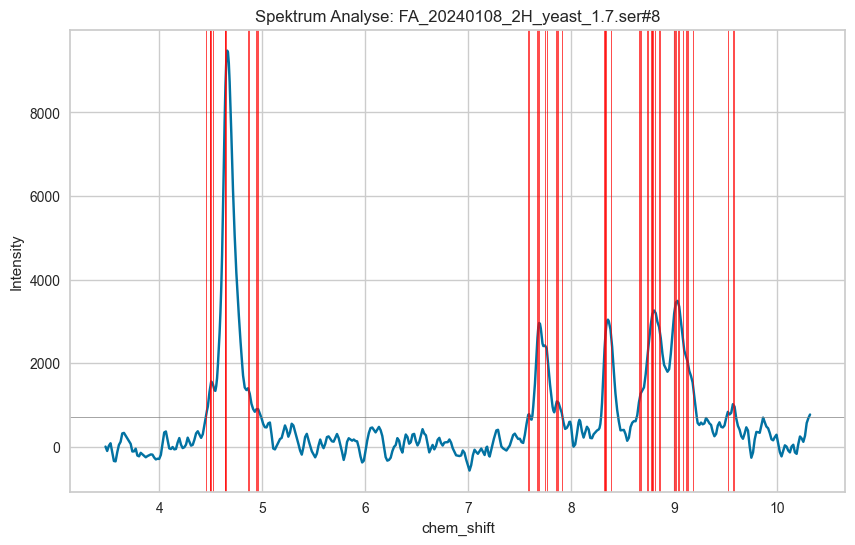

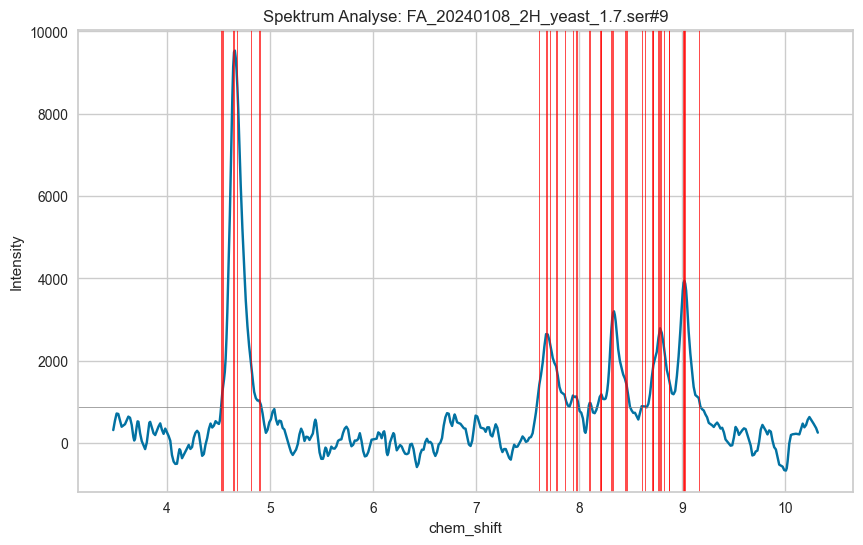

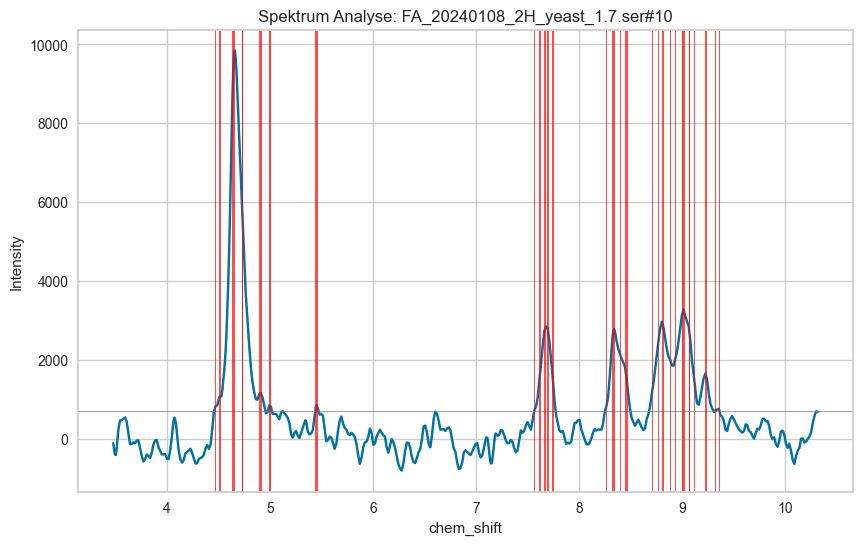

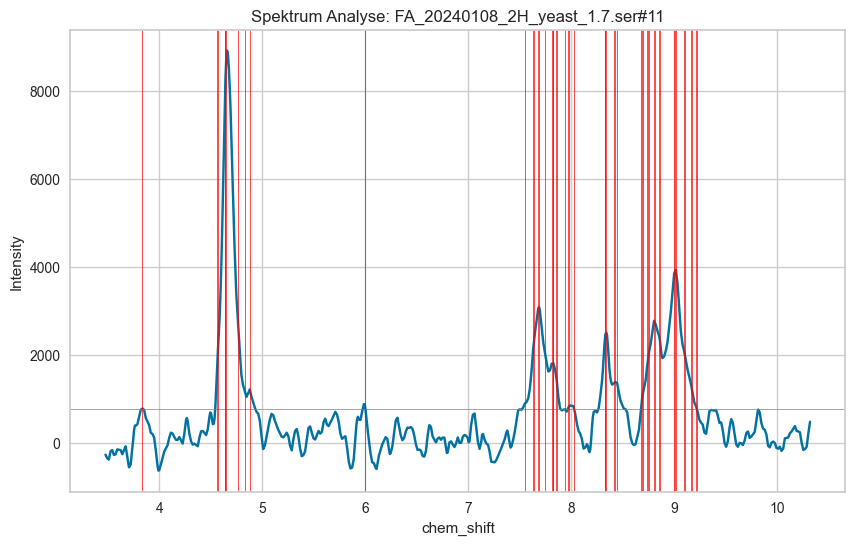

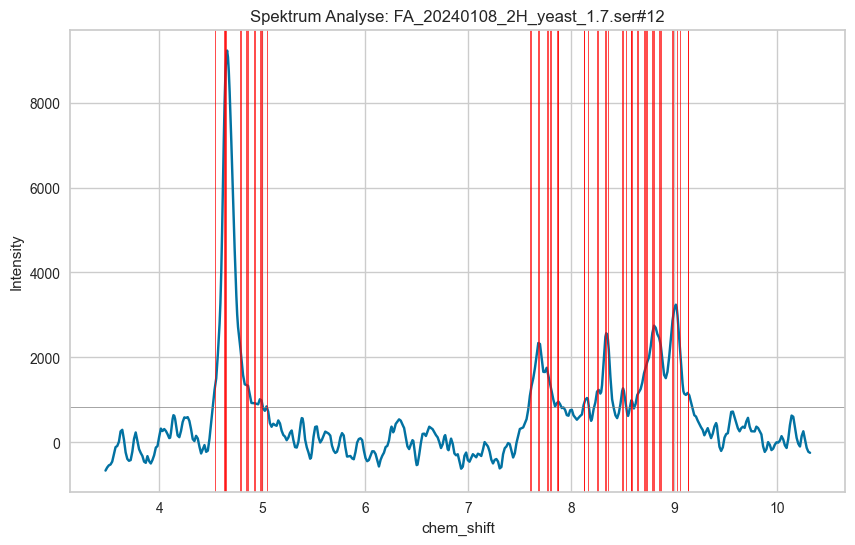

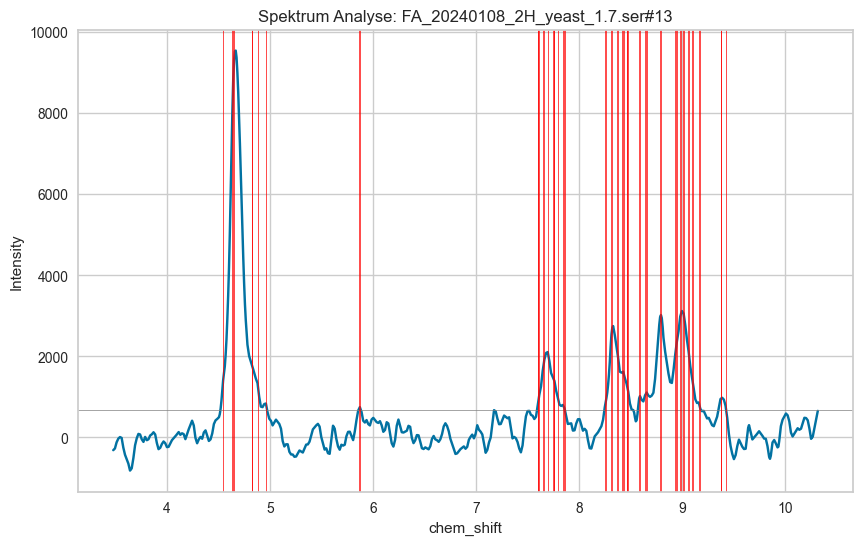

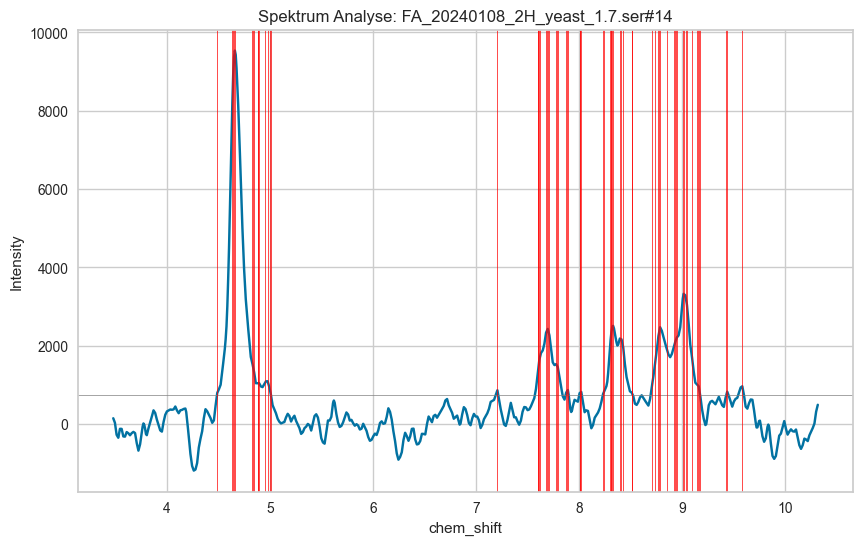

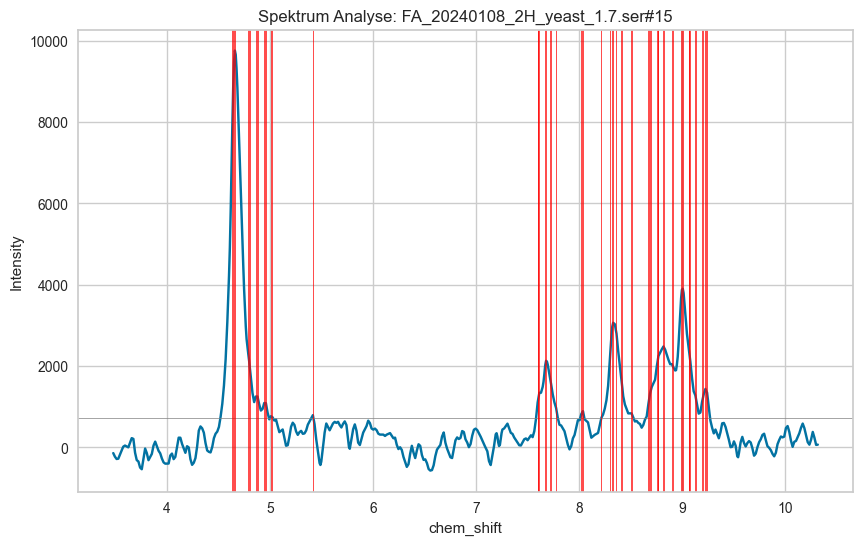

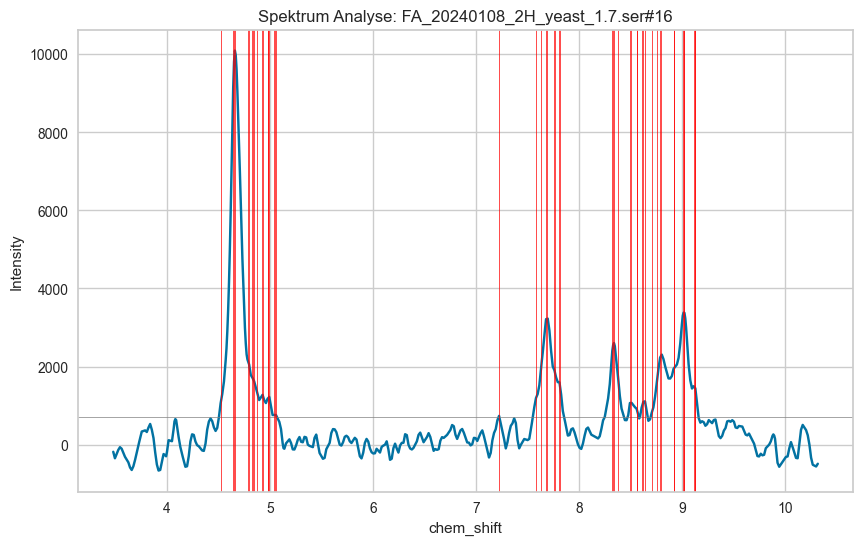

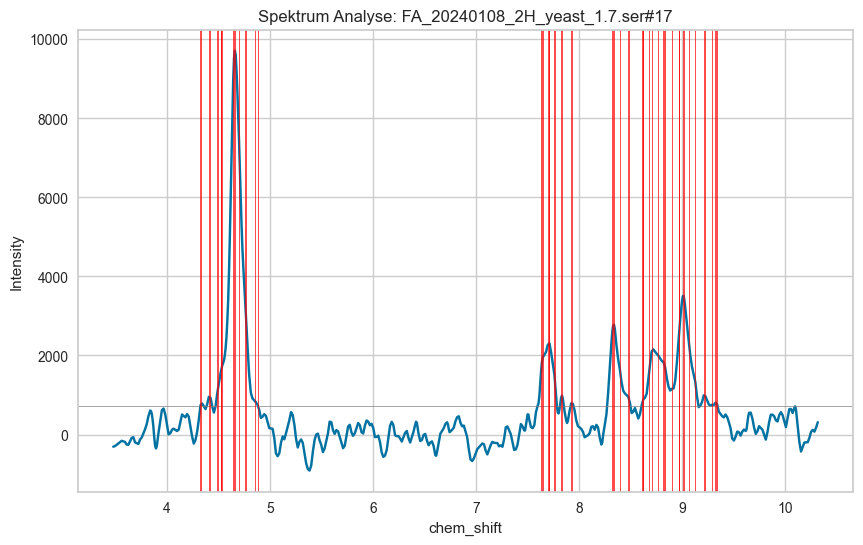

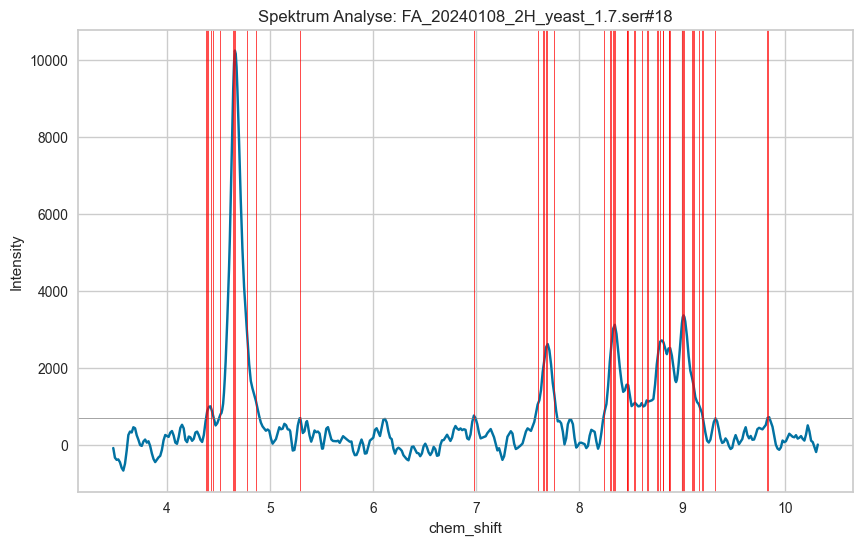

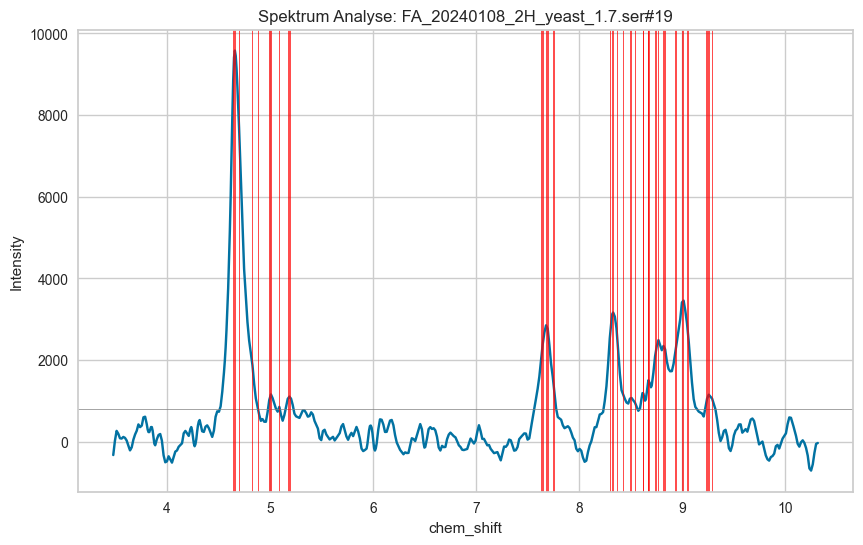

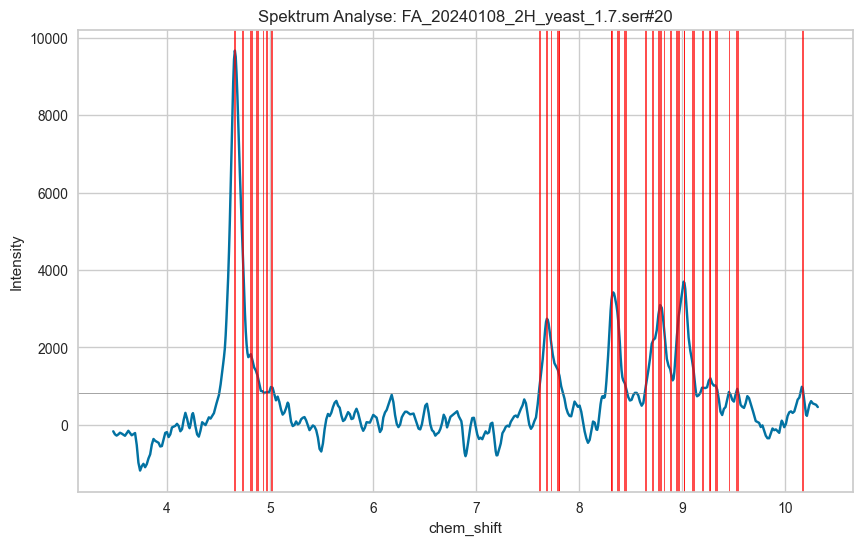

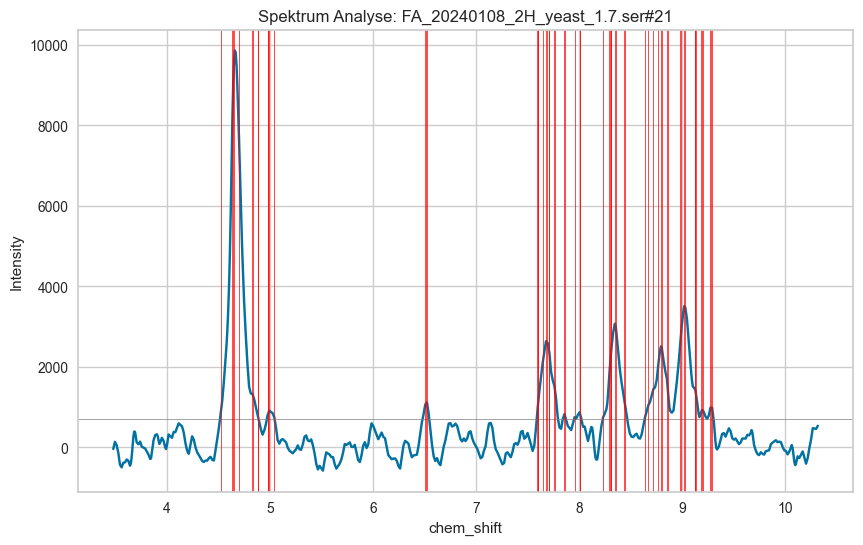

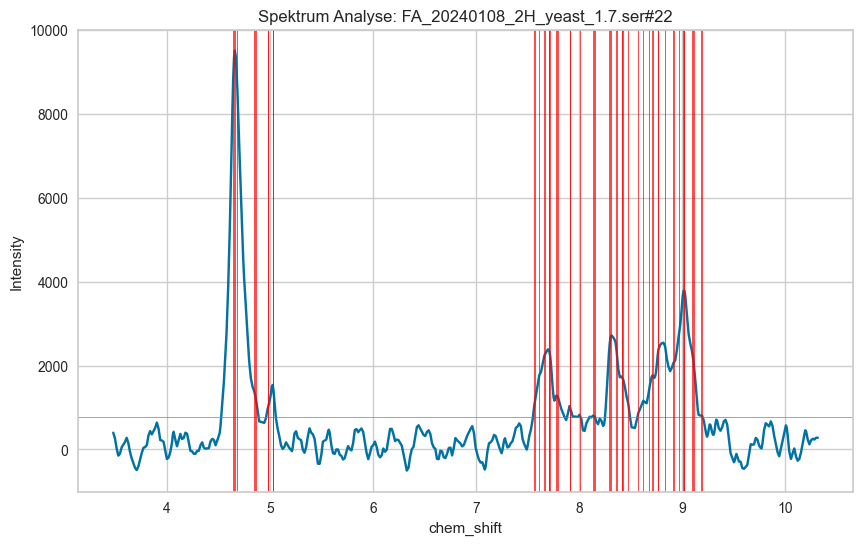

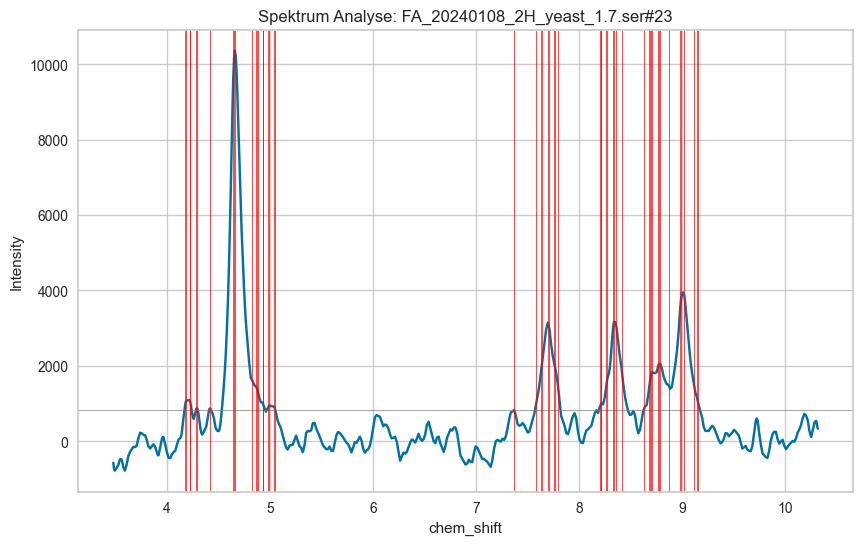

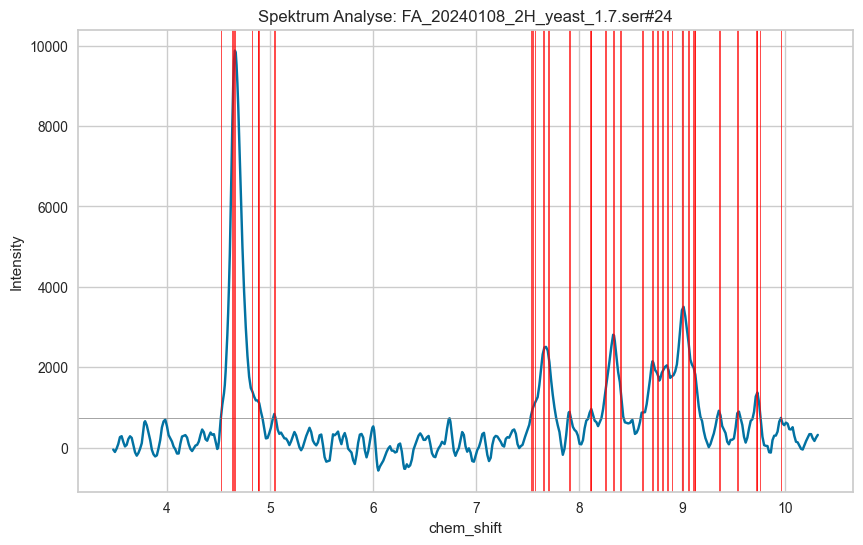

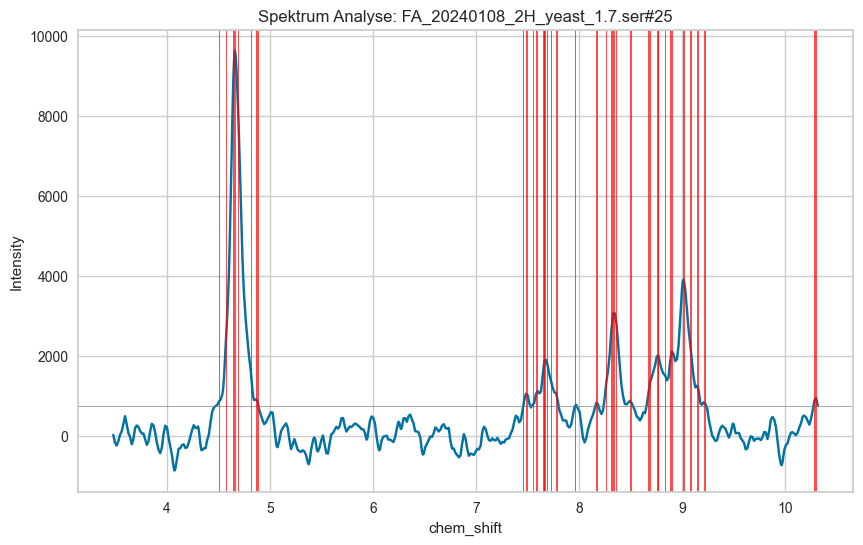

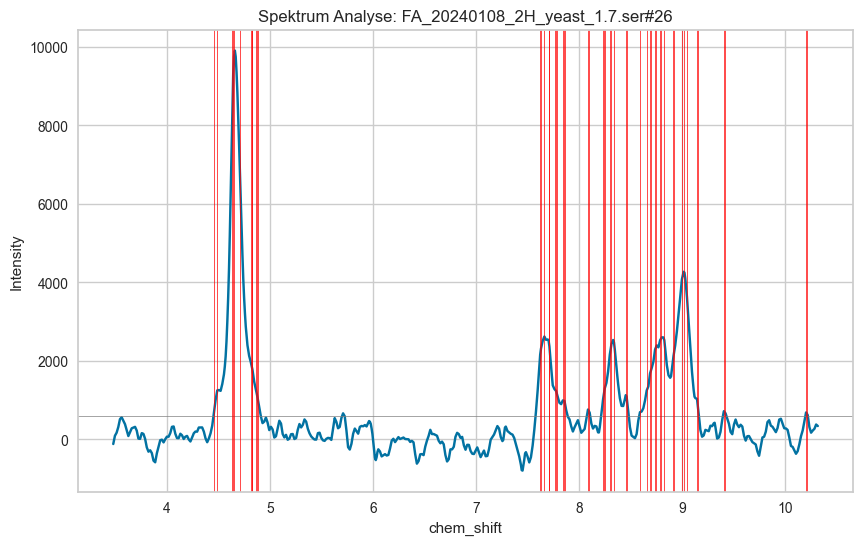

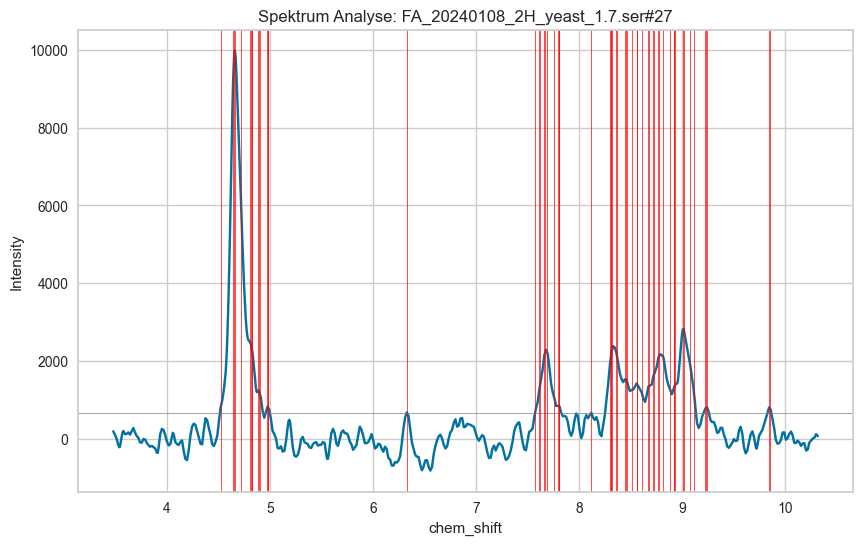

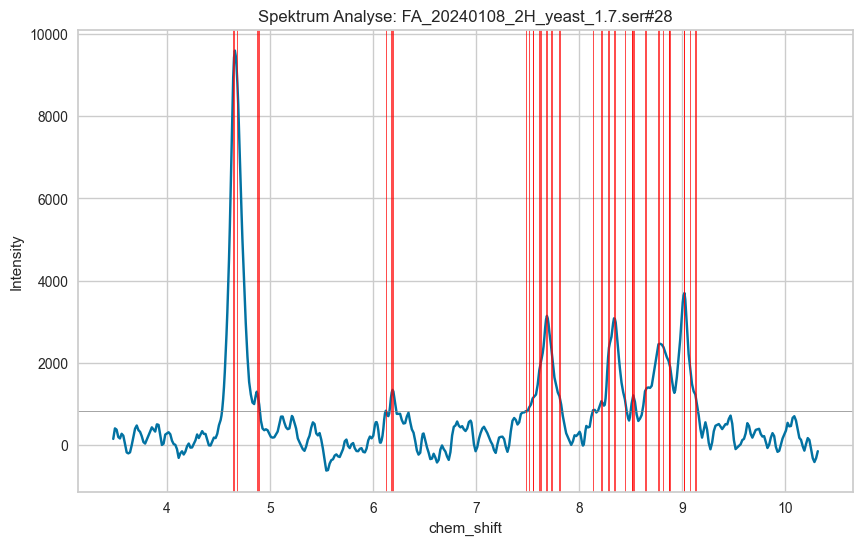

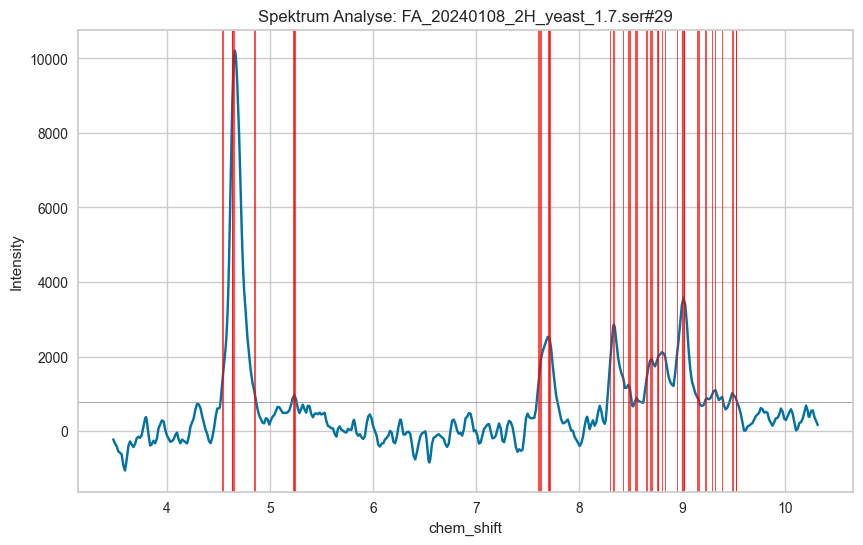

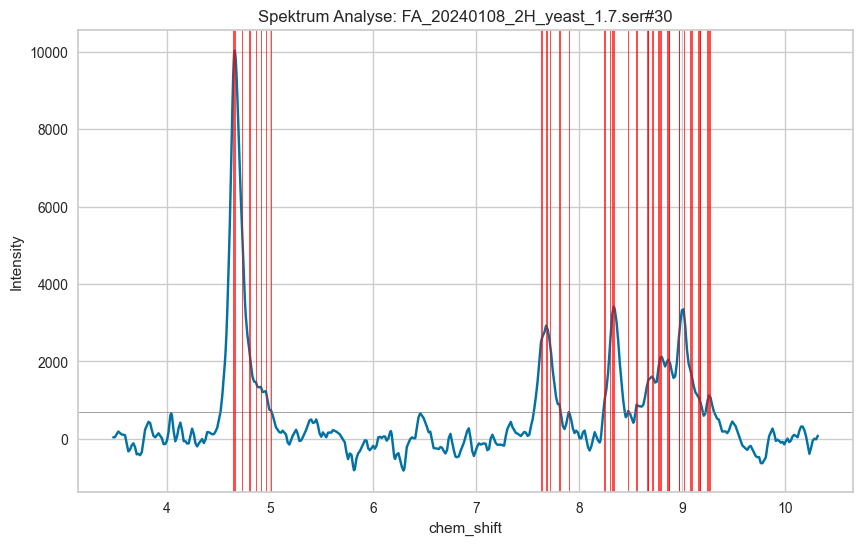

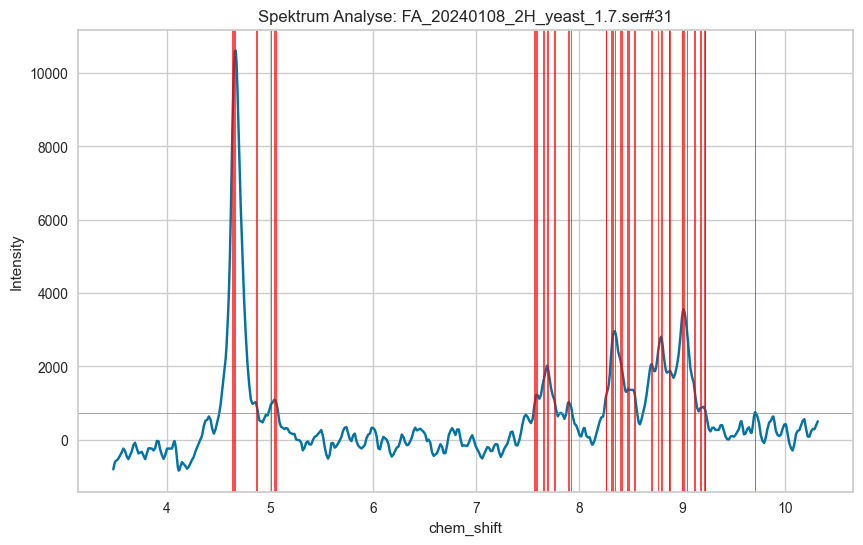

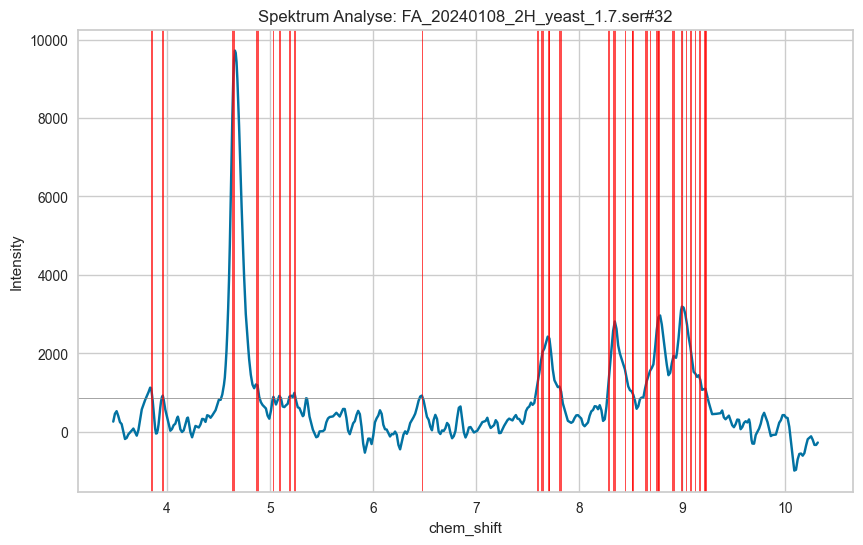

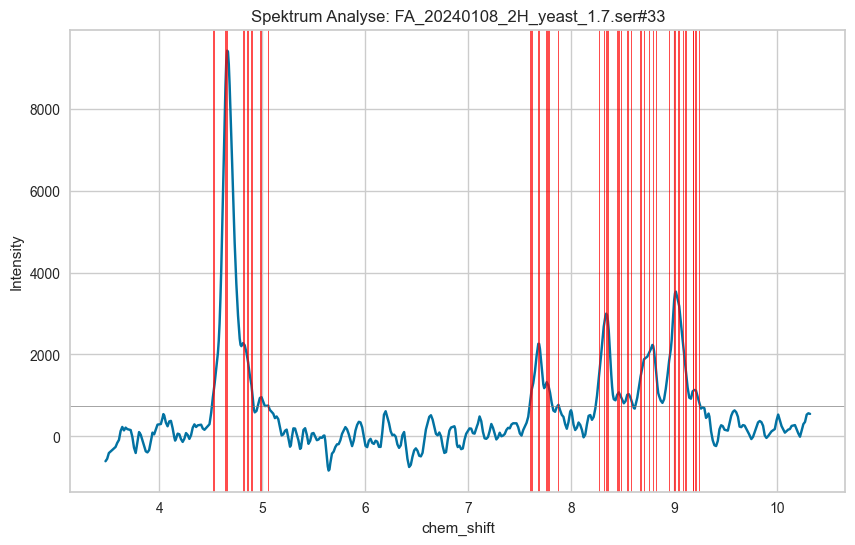

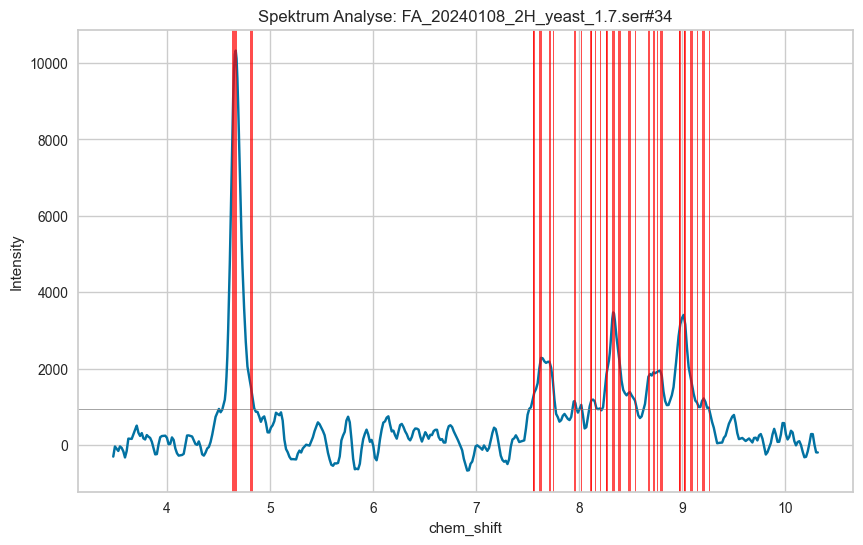

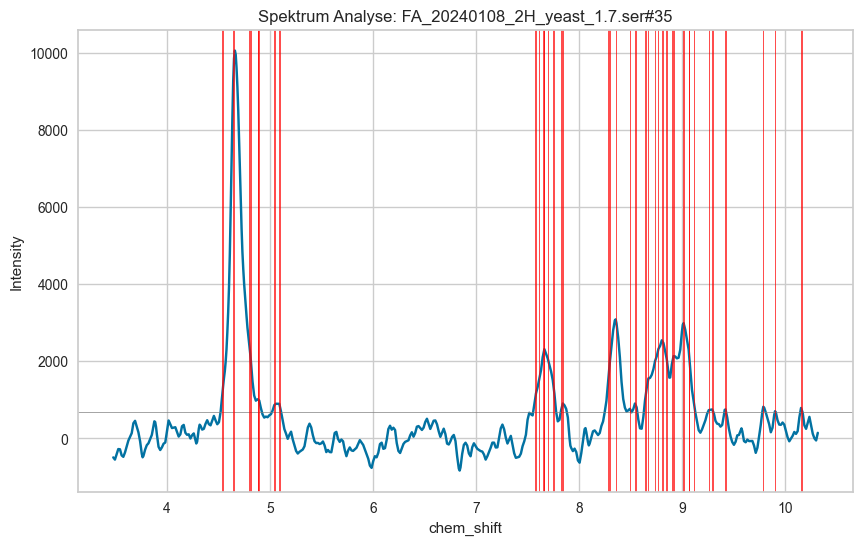

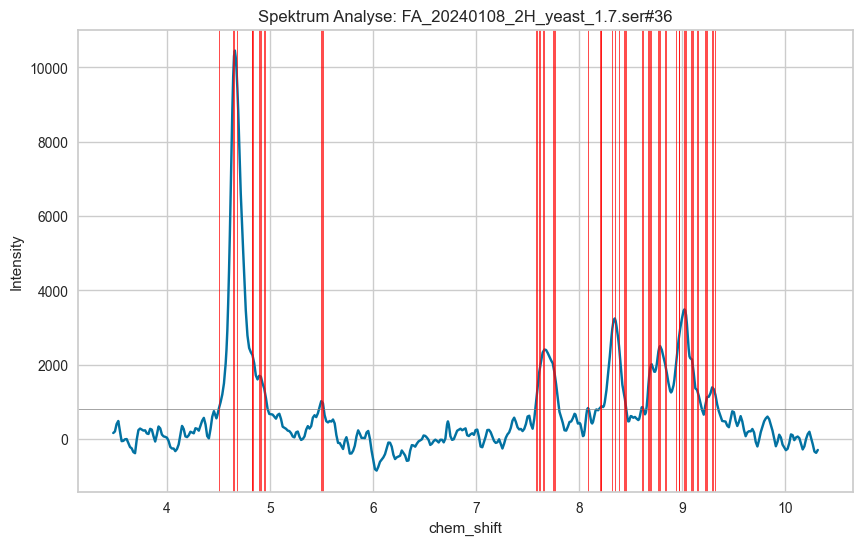

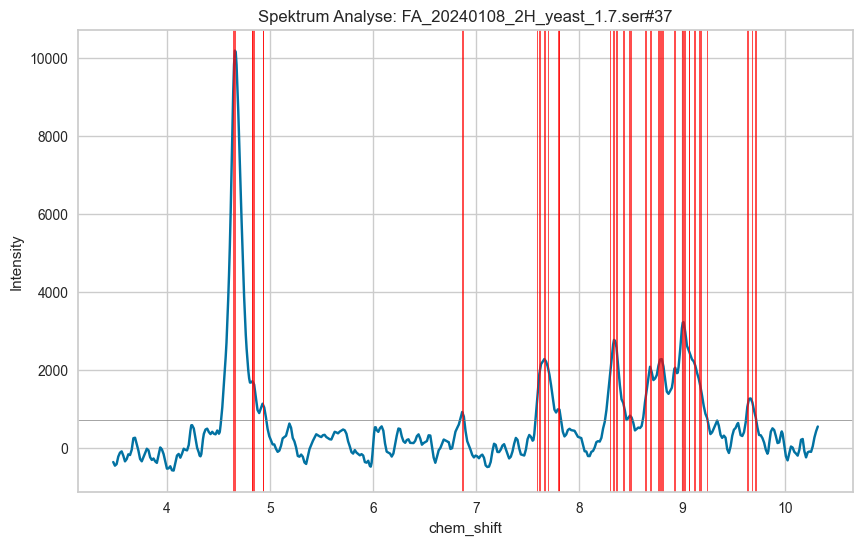

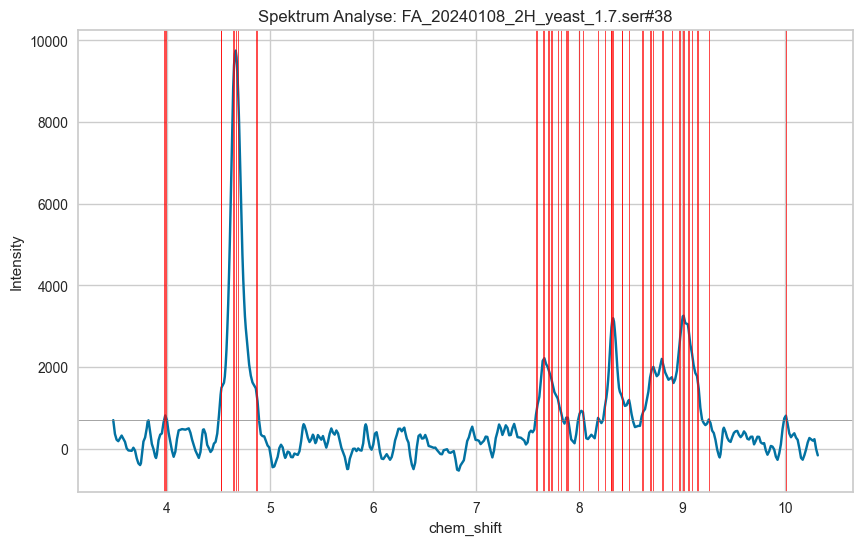

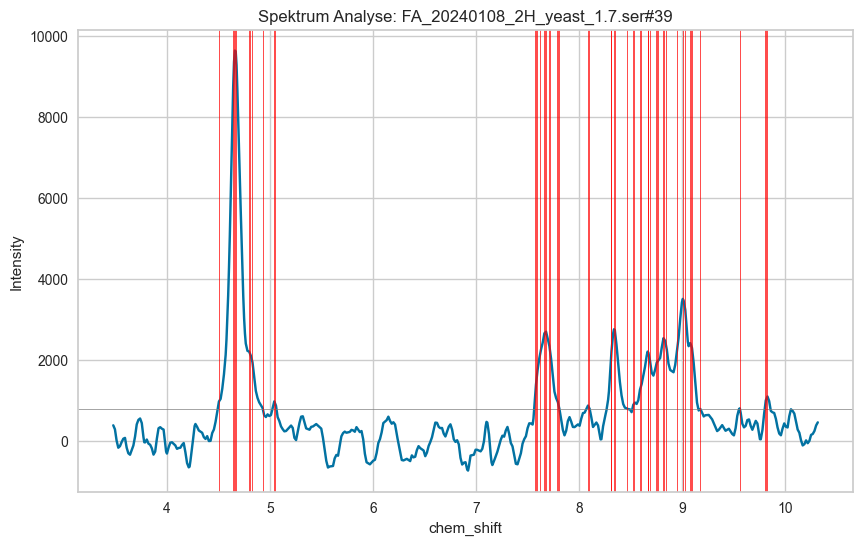

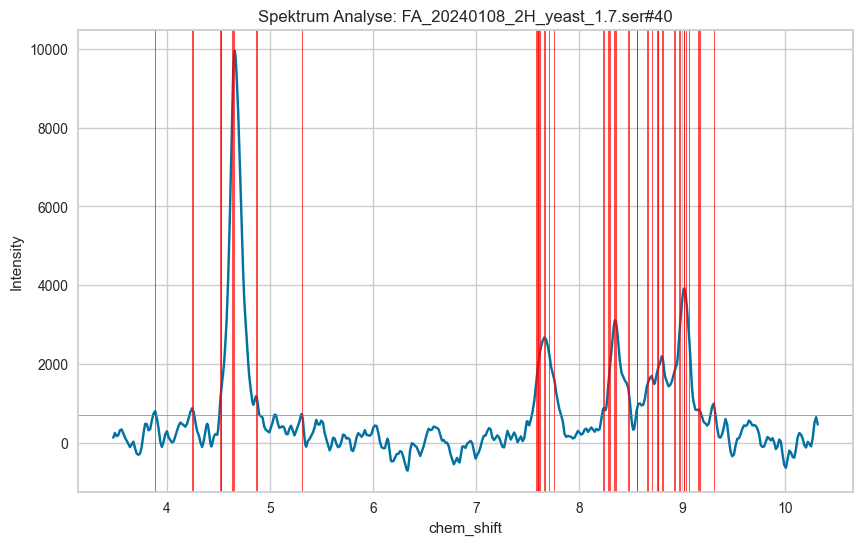

In [11]:
individual_peak_analysis('FA_20240108_2H_yeast_Nicotinamide-d4 _7.csv')